In [1]:
import polars as pl
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
import numpy as np
import geopandas as gpd
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from sklearn.decomposition import PCA
import dill as pickle
import os
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, SplineTransformer, KernelCenterer, PolynomialFeatures, PowerTransformer, QuantileTransformer, Normalizer
from itertools import chain
import math
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:


def make_relative_ternary(df:pl.DataFrame, expectations=None):
    if expectations is None:
        #We can do this all as one statement with polars ofc but want to save training expectations so they can be applied to test data
        expectations = df.with_columns(pl.col('target').mean().over(['muni_id', 'month']).alias('expected')).group_by(['muni_id', 'month']).agg(pl.col('expected').first()).sort('month')

    return (
            (
                df
                .join(expectations, on=['muni_id', 'month'])
                .with_columns(
                    pl.when(pl.col('target')<=pl.col('expected')*.5)
                    .then(pl.lit('0'))
                    .when((pl.col('target')>pl.col('expected')*.5)&(pl.col('target')<=pl.col('expected')))
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('2'))
                    .alias('cat_target')
                    )
                .select(pl.exclude('expected'))
            ),
            expectations
    )


In [3]:
monthly_cases = pl.read_parquet('../data/cases/agged/dengue_per_month.parquet').with_columns(pl.col('DT_NOTIFIC').dt.offset_by('1mo').alias('end_date')).with_columns(pl.col('ID_MUNICIP').str.slice(offset=0,length=6).cast(pl.Int64)).sort('DT_NOTIFIC').rename({
'DT_NOTIFIC': 'start_date',
'ID_MUNICIP': 'muni_id'
})

monthly_params = pl.read_parquet('../data/gee_exports_test/all_parameters_2001-01-01_2021-01-01_months.parquet')

ALL_DATA = monthly_cases.join(monthly_params, how='inner', on=['muni_id', 'end_date']).with_columns(pl.col('end_date').alias('month').dt.month())
TRAIN_START = '2005-01-01'
TRAIN_END = '2018-01-01'

TEST_START = '2018-01-01'
TEST_END = '2020-01-01'

EL = 12
LC = 24
binary_error = [np.array([-999.0, -999.0])]
ternary_error = [np.array([-999.0, -999.0, -999.0])]
SAVE_DIR = '/home/tony/dengue/dengue_models/results/'
SAVE_PREFIX = 'relative_binary_global'
CAT_STYLE = 'relative_binary_global'
CAT_FN = make_relative_ternary
ERROR_ARR = binary_error
munis = gpd.read_file('../data/brazil/munis/munis_simple.shp').astype({'CD_MUN': 'string'})
munis['CD_MUN'] = munis['CD_MUN'].str.slice(stop=-1).astype(int)
ALL_DATA = ALL_DATA.join(pl.DataFrame(munis.drop(columns='geometry')), how='left', left_on='muni_id', right_on='CD_MUN').select(pl.exclude(['NM_MUN', 
                                                                                          'geometry'])).with_columns((pl.col('pop')/pl.col('AREA_KM2')).alias('density'))

In [195]:
ALL_DATA.columns

['muni_id',
 'start_date',
 'count',
 'x_centroid',
 'y_centroid',
 'pop',
 'year',
 'cases_per_100k',
 'end_date',
 'temporal_sdm_both',
 'start_date_right',
 'temporal_sdm_albopictus',
 'start_date_temporal_sdm_albopictus',
 'temporal_sdm_aegypti',
 'start_date_temporal_sdm_aegypti',
 'EVI',
 'start_date_EVI',
 'total_evaporation_sum',
 'start_date_total_evaporation_sum',
 'total_precipitation_sum',
 'start_date_total_precipitation_sum',
 'evaporation_from_open_water_surfaces_excluding_oceans_min',
 'start_date_evaporation_from_open_water_surfaces_excluding_oceans_min',
 'soil_temperature_level_1',
 'start_date_soil_temperature_level_1',
 'runoff_sum',
 'start_date_runoff_sum',
 'surface_runoff_min',
 'start_date_surface_runoff_min',
 'volumetric_soil_water_layer_1',
 'start_date_volumetric_soil_water_layer_1',
 'dewpoint_temperature_2m',
 'start_date_dewpoint_temperature_2m',
 'temperature_2m',
 'start_date_temperature_2m',
 'total_precipitation_min',
 'start_date_total_precipitatio

In [4]:

def create_data_dict(start_date, 
                    end_date, 
                    all_data: pl.DataFrame, 
                    target_var = 'cases_per_100k',
                    case_lookback=24,
                    case_lag=1,
                    env_lag=0, 
                    env_lookback = 12,
                    env_list = [
                    # 'total_precipitation_sum', 
                    # 'temperature_2m', 
                    ],
                    additional_features = [
                        'month', 
                        # 'pop', 
                        # 'density', 
                        # 'x_centroid', 
                        # 'y_centroid'
                        ],
                    categorical_features = [
                        'month',
                        'SIGLA'
                    ],
                    return_dict = True,
                    specific_cases = None,
                    specific_env = None
                    ):
    to_return = (
        all_data
        #.with_columns(pl.col('muni_id').alias('muni_cat'))
        .select(['muni_id', 'start_date', target_var] + env_list + additional_features)
        .filter((pl.col('start_date')>=datetime.fromisoformat(start_date)-relativedelta(years=math.ceil(case_lookback/12))) & (pl.col('start_date')<datetime.fromisoformat(end_date)))
        .with_columns(
            list(
                chain.from_iterable(
                    [
                        [pl.col(target_var).shift(i).over('muni_id').alias(f'{i}_shifted_cases')] for i in (range(case_lag,case_lookback+case_lag) if specific_cases is None else specific_cases)
                    ]
                    +
                    
                    [
                        [pl.col(e_var).shift(i).over('muni_id').alias(f'{i}_shifted_{e_var}') for i in (range(env_lag,env_lookback+env_lag) if specific_env is None else specific_env)] 
                            for e_var in env_list
                    ]
                    )
                )
        )
        .drop_nulls()
        .select(pl.exclude(env_list))
        .rename({target_var: 'target'})
    )

    return to_return if not return_dict else to_return.partition_by('muni_id', as_dict=True)

In [5]:
def get_features_for_muni(df, cat_fn=None, check_zeros=False):
    df = df.sort('start_date')
    if check_zeros:
        if df.select(pl.col('target')).to_series().sum() == 0:
            return None
    selected = df if cat_fn is None else cat_fn(df)
    expectations = None
    #Some cat_fns return a tuple including expectations for category breaks based on historical data. If so, we want to pass these from training to testing data.
    if isinstance(selected, tuple):
        selected, expectations = selected
    target_key = 'target' if cat_fn is None else 'cat_target'
    target = selected.select(pl.col(target_key)).to_series().to_numpy().astype(float) 
    
    #TODO: Fix how months are handled
    features = selected.select(pl.exclude(['muni_id', 'start_date', 'target', 'count', 'cat_target'])).to_pandas()
    dates = selected.select(pl.col('start_date')).to_series()
    muni_id = selected.select(pl.col('muni_id').first()).item()

    return {'X': features,
            'y': target,
            'dates': dates,
            'muni_id': muni_id,
            'expectations': expectations}

In [6]:
def handle_zero_case(muni_id):
    return pl.DataFrame({
        'predictions': [-999.0],
        'ground_truth': [-999.0],
        'date': [datetime.fromisoformat('1900-01-01')],
        'muni_id': [muni_id],
        'cat_style': ['NA'],
        'error': ['Only zeros in training data'],
        'probabilities': ERROR_ARR
    }).cast({'date':pl.Date})

In [7]:

def write_results(df: pl.DataFrame, save_dir, save_prefix, muni_id):
    #muni_id = df.select('muni_id').head(n=1).item()
    df.write_csv(os.path.join(save_dir, f'{muni_id}_{save_prefix}.csv'))

In [8]:
def make_simple_binary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([300], labels=['0','1']).alias('cat_target'))

In [9]:

def make_simple_ternary(df:pl.DataFrame):
    return df.with_columns(pl.col('target').cut([100,300], labels=['0','1', '2']).alias('cat_target'))

In [10]:

def make_relative_binary(df:pl.DataFrame, expectations=None):
    if expectations is None:
        #We can do this all as one statement with polars ofc but want to save training expectations so they can be applied to test data
        expectations = df.with_columns(pl.col('target').mean().over(['muni_id','month']).alias('expected')).group_by(['muni_id', 'month']).agg(pl.col('expected').first()).sort('month')

    return (
            (
                df
                .join(expectations, on=['muni_id', 'month'])
                .with_columns(
                    pl.when(pl.col('target')>pl.col('expected'))
                    .then(pl.lit('1'))
                    .otherwise(pl.lit('0'))
                    .alias('cat_target')
                    )
                .select(pl.exclude('expected'))
            ),
            expectations
    )

In [275]:
from sklearn.compose import make_column_selector
def train_global(train, cat_style='', train_transform=None, target_transform=None, ct=None):

    #n_components = 15
    n_components = train['X'].shape[1]
    print(n_components)
    
    reg = HistGradientBoostingClassifier(
    random_state=42,
    loss='log_loss',
    categorical_features = [n_components-1],
    #l2_regularization=10.0,
    #categorical_features=[15],
    max_iter=10000, 
    #learning_rate=0.5,
    #max_leaf_nodes=63, 
    #min_samples_leaf=40,
    #max_bins=150,
    early_stopping=True,
    class_weight='balanced',
    validation_fraction=0.3,
    n_iter_no_change=100,
    scoring='f1_macro'
    )

    if ct is None:
        ct = ColumnTransformer([
            #('min_max', MinMaxScaler(), list(range(0, n_components-1))),
            ('min_max', RobustScaler(), make_column_selector(dtype_exclude='uint32')),
        ],
        remainder='passthrough')

    train_x = ct.fit_transform(train['X'])
    print(train_x[:,-1])
    if train_transform is not None:
        train_x = train_transform(train_x)
    #test_x = ct.transform(test['X'])

    train_y = train['y']
    if target_transform is not None:
        train_y = target_transform(train_y)

    #sample_weight = compute_sample_weight('balanced', train['y'])
    reg.fit(train_x, train_y, 
            #sample_weight=sample_weight
            )
    
    return reg, ct

In [13]:
def test_global(model, transformer, test, cat_style):
    test_x = transformer.transform(test['X'])

    z = model.predict(test_x)
    p_hat = model.predict_proba(test_x)
    return pl.DataFrame({
        'predictions': z,
        'ground_truth': test['y'],
        'date': test['dates'],
        'muni_id': [test['muni_id']]*len(z),
        'cat_style': [cat_style]*len(z),
        'error': ['NONE'] * len(z),
        'probabilities': p_hat
    })

In [122]:
def train_models(
        train_transform = None, 
        target_transform = None, 
        ct = None, 
        train_args = {
            'start_date': TRAIN_START,
            'end_date': TRAIN_END,
            'all_data': ALL_DATA,
            'env_list': [],
            'return_dict': False
        },
        test_args = {
            'start_date': TEST_START,
            'end_date': TEST_END,
            'all_data': ALL_DATA,
            'env_list': [],
            'return_dict': False
        }
):

    global_data = create_data_dict(**train_args)
    global_data = (
        global_data
        .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
        #.filter(pl.col('muni_sum')!=0)
        #.select(pl.exclude('muni_sum'))
    )

    skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
    global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))

    test_data= create_data_dict(**test_args).filter(~pl.col('muni_id').is_in(skip_munis))

    train_data = get_features_for_muni(global_data, CAT_FN, check_zeros=False)
    expectations = train_data['expectations']
    global_model, col_transformer = train_global(train_data,cat_style=CAT_STYLE, train_transform=train_transform, target_transform=target_transform, ct=ct)


    new_cat_fn = partial(CAT_FN, expectations = expectations)
    test_data = get_features_for_muni(test_data, new_cat_fn, check_zeros=False)



    results = test_global(global_model, col_transformer, test_data, CAT_STYLE)

    return results

In [123]:
predictions = train_models()

29


In [124]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81     90657
         1.0       0.17      0.55      0.26      7933
         2.0       0.60      0.62      0.61     30242

    accuracy                           0.69    128832
   macro avg       0.56      0.63      0.56    128832
weighted avg       0.79      0.69      0.73    128832



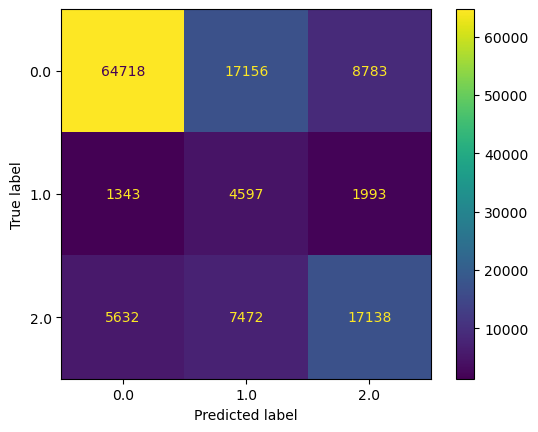

In [94]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 1: Random null training features
Results: Doesn't seem to have a large impact on accuracy. Having up to 85% of values missing doesn't even make much of an impact. There is a lot of noise

In [73]:
import numpy as np

def random_null(inp: np.array, p=0.25):
    rng = np.random.default_rng(12345)
    samples = rng.uniform(size=inp.shape)

    inp[samples<=p] = np.nan
    return inp


In [106]:
predictions = train_models(random_null)

26


In [75]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     90657
         1.0       0.16      0.57      0.25      7933
         2.0       0.61      0.57      0.59     30242

    accuracy                           0.67    128832
   macro avg       0.56      0.62      0.54    128832
weighted avg       0.79      0.67      0.71    128832



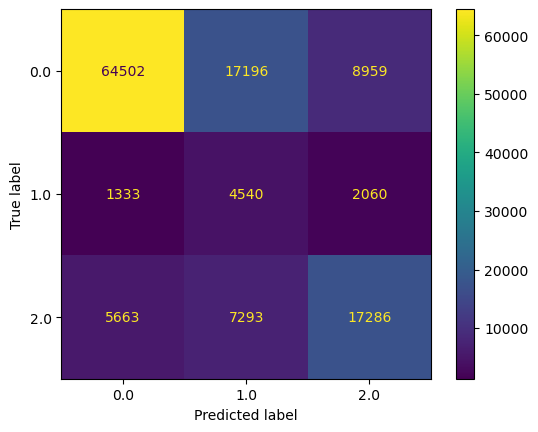

In [76]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 2: Additional random null training features
Results: Slows things down a lot, does not significantly improve results

In [99]:
import numpy as np

def random_null_add(inp: np.array, p=0.25):
    rng = np.random.default_rng(12345)
    samples = rng.uniform(size=inp.shape)
    copied = np.copy(inp)
    copied[samples<=p] = np.nan
    return np.concatenate((inp, copied))

def training_double(inp: np.array):
    return np.concatenate((inp, inp))


In [100]:
predictions = train_models(train_transform=random_null_add, target_transform=training_double)

In [101]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.75      0.81     90657
         1.0       0.16      0.46      0.24      7933
         2.0       0.59      0.60      0.60     30242

    accuracy                           0.70    128832
   macro avg       0.55      0.60      0.55    128832
weighted avg       0.78      0.70      0.73    128832



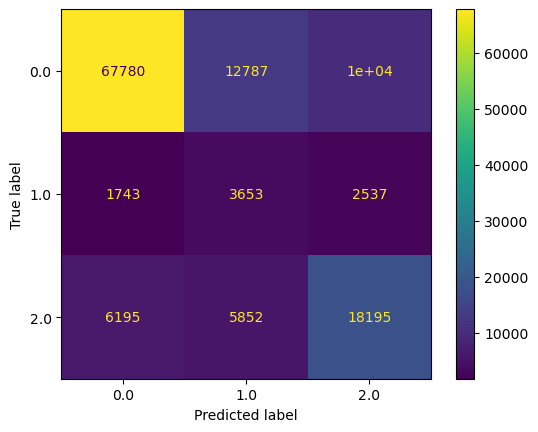

In [102]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

##Test 3: Adding PCA 
Results: Improves things? need to test more

In [101]:
pca_trans = ColumnTransformer([
            ('min_max', RobustScaler(), list(range(1, 26))),
            ('pca', PCA(n_components=10), list(range(1, 26)))
        ],
        remainder='passthrough')

In [102]:
predictions = train_models(ct=pca_trans)

27


/home/tony/mambaforge/envs/new_dengue/lib/python3.11/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1998: FutureWarning: The loss 'categorical_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


In [104]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     90657
         1.0       0.16      0.54      0.25      7933
         2.0       0.61      0.58      0.60     30242

    accuracy                           0.68    128832
   macro avg       0.56      0.62      0.55    128832
weighted avg       0.79      0.68      0.72    128832



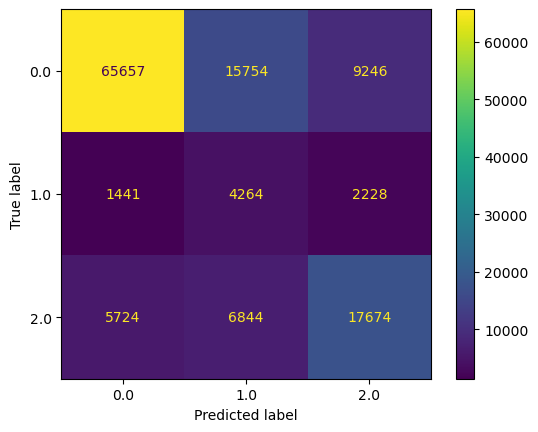

In [105]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

Test 3: Time Lag Search

In [231]:
global_data = create_data_dict(TRAIN_START, TRAIN_END, ALL_DATA, env_list=[
    'temporal_sdm_both',
    # 'temporal_sdm_albopictus',
    # 'temporal_sdm_aegypti',
    # 'EVI',
    # 'total_evaporation_sum',
    # 'total_precipitation_sum',
    # 'evaporation_from_open_water_surfaces_excluding_oceans_min',
    # 'soil_temperature_level_1',
    # 'runoff_sum',
    # 'surface_runoff_min',
    # 'volumetric_soil_water_layer_1',
    # 'dewpoint_temperature_2m',
    # 'temperature_2m',
    # 'total_precipitation_min'
], specific_cases= [1,12, 24],
additional_features= [
                'month',
                'density',
                'pop'
            ],
            return_dict=False)
global_data = (
    global_data
    .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
    #.filter(pl.col('muni_sum')!=0)
    #.select(pl.exclude('muni_sum'))
)

skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))
train_data = get_features_for_muni(global_data, CAT_FN, check_zeros=False)

In [251]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif, mutual_info_classif
X, y = train_data['X'], train_data['y']
ct = ColumnTransformer([
            #('min_max', MinMaxScaler(), list(range(0, n_components-1))),
            ('min_max', Normalizer(), make_column_selector(dtype_exclude='uint32')),
        ],
        remainder='passthrough')
ct.fit_transform(X)


array([[1.01949610e-03, 9.99999255e-01, 5.99117746e-04, ...,
        9.89599141e-06, 1.23014259e-05, 2.00000000e+00],
       [4.56943818e-03, 9.99989560e-01, 5.64560251e-06, ...,
        2.23354917e-07, 4.42902702e-07, 2.00000000e+00],
       [2.55900896e-03, 9.99996725e-01, 1.51430227e-05, ...,
        2.01916999e-06, 2.11677073e-06, 2.00000000e+00],
       ...,
       [2.76636358e-03, 9.99996171e-01, 0.00000000e+00, ...,
        6.67583997e-06, 3.71316942e-06, 1.00000000e+00],
       [2.46504398e-03, 9.99996855e-01, 0.00000000e+00, ...,
        1.43076320e-04, 1.52692525e-04, 1.00000000e+00],
       [2.93259026e-03, 9.99995684e-01, 0.00000000e+00, ...,
        1.06904122e-05, 1.64877864e-05, 1.00000000e+00]])

Months since last peak feature??? Or is this captured by historic

Position within relative dengue season

Change rates instead of hi/low/medium classfication
changing rapidly up, down, medium

fit some kind of periodic function per municipio based on standardized case rates -> model that takes periodic function fit to standardized data so that all municipios you can reapply results to own actual period function - look at peaks

In [117]:
from sklearn.feature_selection import SequentialFeatureSelector

hist_model = HistGradientBoostingClassifier(random_state=42,
    #categorical_features = [n_components-1],
    #l2_regularization=.05,
    #categorical_features=[15],
    max_iter=500, 
    #learning_rate=0.5,
    #max_leaf_nodes=None, 
    #min_samples_leaf=10,
    #max_bins=255,
    early_stopping=True,
    class_weight='balanced',
    validation_fraction=0.3,
    n_iter_no_change=100)
#X = MinMaxScaler().fit_transform(X)
sfs = SequentialFeatureSelector(hist_model, n_features_to_select='auto', tol=0.001, scoring='f1_macro', cv=3, n_jobs=-1)
sfs.fit(X, y)

SequentialFeatureSelector(cv=3,
                          estimator=HistGradientBoostingClassifier(class_weight='balanced',
                                                                   early_stopping=True,
                                                                   max_iter=500,
                                                                   n_iter_no_change=100,
                                                                   random_state=42,
                                                                   validation_fraction=0.3),
                          n_features_to_select='auto', n_jobs=-1,
                          scoring='f1_macro', tol=0.001)

In [118]:
sfs.get_feature_names_out(
)

array(['1_shifted_cases', '13_shifted_cases', '24_shifted_cases',
       '8_shifted_surface_runoff_min'], dtype=object)

Test 4: non-contiguous time period
Results: Inconclusive


In [276]:
predictions = train_models(train_args = {
            'start_date': TRAIN_START,
            'end_date': TRAIN_END,
            'all_data': ALL_DATA,
            'env_list': [
                'temporal_sdm_aegypti',
                'temporal_sdm_albopictus',
                #'temporal_sdm_both'
                ],
            'return_dict': False,
            'specific_cases': [1,2,12, 24],
            'specific_env': [0,1,2, 11, 23],
            'additional_features': [
                'month',
                'density',
                'pop'
            ]
        },
        test_args = {
            'start_date': TEST_START,
            'end_date': TEST_END,
            'all_data': ALL_DATA,
            'env_list': [
                'temporal_sdm_aegypti',
                'temporal_sdm_albopictus',
                #'temporal_sdm_both'
                ],
            'return_dict': False,
            'specific_cases': [1,2, 12, 24],
            'specific_env': [0,1,2, 11, 23],
            'additional_features': [
                'month',
                'density',
                'pop'
            ]
        }
)

17
[2. 2. 2. ... 1. 1. 1.]


In [277]:
print(classification_report(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series()))

              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     90657
         1.0       0.16      0.55      0.25      7933
         2.0       0.60      0.58      0.59     30242

    accuracy                           0.68    128832
   macro avg       0.55      0.62      0.55    128832
weighted avg       0.79      0.68      0.72    128832



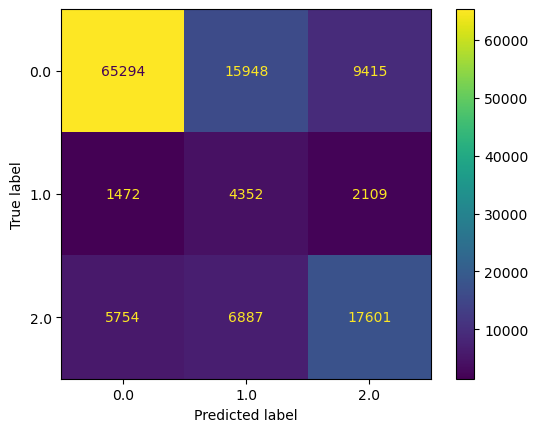

In [278]:
ConfusionMatrixDisplay.from_predictions(predictions.select('ground_truth').to_series(),predictions.select('predictions').to_series())

5: Setting up timeseries kfold validation for tests:

In [7]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate

splitter = TimeSeriesSplit()
global_data = create_data_dict('2001-01-01', '2020-11-01', ALL_DATA, env_list=[
], specific_cases= [1,12, 24],
additional_features= [
                'month',
                'density',
                'pop'
            ],
            return_dict=False)
global_data = (
    global_data
    .with_columns(pl.col('target').sum().over('muni_id').alias('muni_sum'))
)

skip_munis = global_data.filter(pl.col('muni_sum') == 0).select('muni_id').unique().to_series()
global_data = global_data.filter(pl.col('muni_sum')!=0).select(pl.exclude('muni_sum'))
train_data = get_features_for_muni(global_data, CAT_FN, check_zeros=False)


In [10]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

cat_columns = ['month']

scaler = make_column_transformer(
    (RobustScaler(), make_column_selector(dtype_exclude='uint32')), remainder="passthrough", verbose_feature_names_out=False,
)


hist_model = HistGradientBoostingClassifier(
    random_state=42,
    max_iter=250, 
    early_stopping=True,
    class_weight='balanced',
    categorical_features=cat_columns
    )
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=50,
    criterion='entropy'
)
hist_pipeline = make_pipeline(scaler, hist_model).set_output(transform='pandas')
rf_pipeline = make_pipeline(scaler, rf_model).set_output(transform='pandas')
vote_pipeline = make_pipeline(scaler, VotingClassifier([('hist', hist_model), ('rf', rf_model)])).set_output(transform='pandas')
#voter = VotingClassifier([hist_pipeline, rf_pipeline])

cross_validate(vote_pipeline, train_data['X'], train_data['y'], scoring=['f1_macro', 'f1_weighted', 'balanced_accuracy'], cv=TimeSeriesSplit(), n_jobs=-1)


{'fit_time': array([ 24.73059845,  55.08689475,  94.37093258, 132.79846907,
        169.16190624]),
 'score_time': array([4.31449771, 5.07045603, 6.42933035, 6.69864535, 6.02812672]),
 'test_f1_macro': array([0.46128858, 0.4893981 , 0.4986646 , 0.51690755, 0.53363737]),
 'test_f1_weighted': array([0.78509446, 0.75279923, 0.72324714, 0.71819312, 0.74819443]),
 'test_balanced_accuracy': array([0.43813946, 0.46399753, 0.47555158, 0.49815281, 0.51156919])}

TODO: Halvinggridsearch - .02 learning rate best on first try
      Fix categorical variables and try state/cluster membership
      Features seaaaarch better

In [41]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
import scipy.stats as stats

param_grid = {
    'histgradientboostingclassifier__learning_rate': stats.loguniform(.0001, .1 ),
    'histgradientboostingclassifier__l2_regularization': stats.uniform(0,2),
    'histgradientboostingclassifier__max_leaf_nodes': stats.randint(1, 100),
    'histgradientboostingclassifier__min_samples_leaf': stats.randint(1, 100)
}

clf = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=True,
    class_weight='balanced',
    categorical_features=cat_columns
    )

grid_pipeline = make_pipeline(scaler, clf).set_output(transform='pandas')


gsh = HalvingRandomSearchCV(
    estimator=grid_pipeline, param_distributions=param_grid, factor=2, random_state=42, cv=TimeSeriesSplit(n_splits=4), scoring='balanced_accuracy', verbose=1,
    min_resources=100, max_resources=5000, resource='histgradientboostingclassifier__max_iter'
)

search = gsh.fit(train_data['X'], train_data['y'])
#grid_pipeline.named_steps


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 100
max_resources_: 2500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 25
n_resources: 100
Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 

In [38]:
search.cv_results_

{'iter': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]),
 'n_resources': array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 300,
        300, 300, 300, 300, 300, 300, 300, 300, 900, 900, 900]),
 'mean_fit_time': array([ 2.26094635,  1.02120288,  1.20614481,  1.53369697,  4.92304571,
         4.20645634,  5.63758508,  1.08440145,  1.67618783,  1.27316435,
        11.04394094,  1.14466421,  3.38010144,  7.06872161,  4.56787761,
         3.87214144,  4.33379992,  1.59729226,  1.67089248,  3.0994002 ,
         1.36377263,  4.92918619,  2.25477068,  2.23482688,  1.52217642,
         2.29978267,  3.48955154,  4.16823681,  4.40659873,  4.8437771 ,
         5.022686  ,  4.25602436, 19.26879851, 13.54186273,  5.36666417,
        15.23695294, 28.63119125]),
 'std_fit_time': array([ 0.98610204,  0.32496149,  0.4523071 ,  0.8003186